In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()
sys.path.append(str(config.REPO_ROOT))

### 5.1.2 Example

In [2]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike-sharing-daily.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

In [3]:
bike_features_of_interest = [
    "season",
    "holiday",
    "workingday",
    "weathersit",
    "temp",
    "hum",
    "windspeed",
    "days_since_2011",
]

X = df_bike_processed[bike_features_of_interest]
y = df_bike_processed["cnt"]
dat = pd.concat([X, y], axis=1)
model_formula = "cnt ~ " + " + ".join(bike_features_of_interest)
mod = ols(model_formula, data=dat).fit()
lm_summary = mod.summary2().tables[1]
lm_summary["t value"] = np.abs(lm_summary["t"])
lm_summary = lm_summary.rename(index={"Intercept": "Intercept"})
lm_summary_print = lm_summary[["Coef.", "Std.Err.", "t value"]].rename(
    columns={"Coef.": "Weight", "Std.Err.": "SE", "t value": "|t|"}
)
lm_summary_print = lm_summary_print.round(1)

display(lm_summary_print)

,Weight,SE,|t|
Intercept,2399.4,238.3,10.1
season[T.SPRING],899.3,122.3,7.4
season[T.SUMMER],138.2,161.7,0.9
season[T.FALL],425.6,110.8,3.8
holiday[T.HOLIDAY],-686.1,203.3,3.4
workingday[T.WORKING DAY],124.9,73.3,1.7
weathersit[T.MISTY],-379.4,87.6,4.3
weathersit[T.RAIN/SNOW/STORM],-1901.5,223.6,8.5
temp,110.7,7.0,15.7
hum,-17.4,3.2,5.5


### 5.1.3 Visual Interpretation

In [4]:
lm_summary = lm_summary.drop("Intercept").reindex(
    [
        "days_since_2011",
        "holiday[T.HOLIDAY]",
        "hum",
        "season[T.FALL]",
        "season[T.SPRING]",
        "season[T.SUMMER]",
        "temp",
        "weathersit[T.RAIN/SNOW/STORM]",
        "weathersit[T.MISTY]",
        "windspeed",
        "workingday[T.WORKING DAY]",
    ]
)

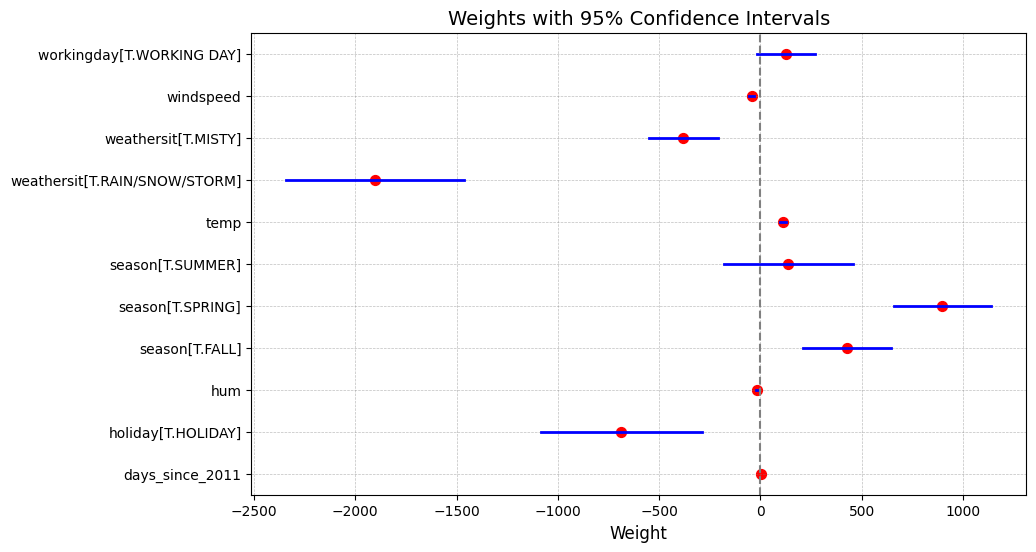

In [5]:
coefs = lm_summary["Coef."]
errors = lm_summary["Std.Err."]
lower_bounds = coefs - 1.96 * errors
upper_bounds = coefs + 1.96 * errors

fig, ax = plt.subplots(figsize=(10, 6))

for i, (lower, upper, coef) in enumerate(zip(lower_bounds, upper_bounds, coefs)):
    if coef == "Intercept":
        continue
    else:
        ax.plot([lower, upper], [i, i], color="blue", linewidth=2)
        ax.scatter(coef, i, color="red", s=50)

ax.axvline(0, linestyle="--", color="gray")
ax.set_xlabel("Weight", fontsize=12)
ax.set_title("Weights with 95% Confidence Intervals", fontsize=14)
ax.set_yticks(range(len(coefs)), lm_summary.index)
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)

plt.show()

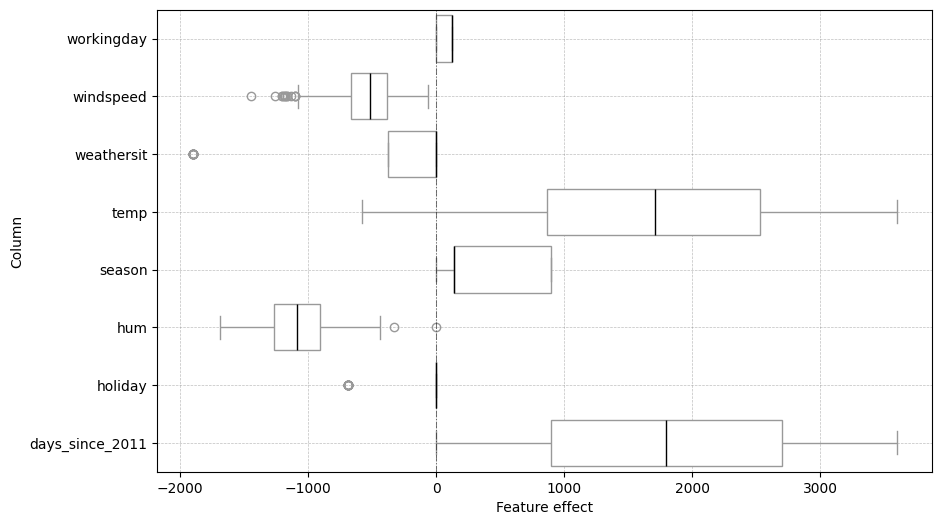

In [6]:
X_dummies = pd.get_dummies(
    X, columns=["season", "holiday", "workingday", "weathersit"], drop_first=True
)
X_dummies = X_dummies.rename(
    columns={
        "season_SPRING": "season[T.SPRING]",
        "season_SUMMER": "season[T.SUMMER]",
        "season_FALL": "season[T.FALL]",
        "holiday_HOLIDAY": "holiday[T.HOLIDAY]",
        "workingday_WORKING DAY": "workingday[T.WORKING DAY]",
        "weathersit_MISTY": "weathersit[T.MISTY]",
        "weathersit_RAIN/SNOW/STORM": "weathersit[T.RAIN/SNOW/STORM]",
    }
)
X_dummies[
    [
        "season[T.SPRING]",
        "season[T.SUMMER]",
        "season[T.FALL]",
        "holiday[T.HOLIDAY]",
        "workingday[T.WORKING DAY]",
        "weathersit[T.MISTY]",
        "weathersit[T.RAIN/SNOW/STORM]",
    ]
] = X_dummies[
    [
        "season[T.SPRING]",
        "season[T.SUMMER]",
        "season[T.FALL]",
        "holiday[T.HOLIDAY]",
        "workingday[T.WORKING DAY]",
        "weathersit[T.MISTY]",
        "weathersit[T.RAIN/SNOW/STORM]",
    ]
].astype(int)

df_effect = (X_dummies * mod.params).dropna(axis=1, how="all")
season_cols = [col for col in df_effect.columns if col.startswith("season[T.")]
df_effect["season"] = df_effect[season_cols].sum(axis=1)
df_effect = df_effect.drop(columns=season_cols)
weathersit_cols = [col for col in df_effect.columns if col.startswith("weathersit[T")]
df_effect["weathersit"] = df_effect[weathersit_cols].sum(axis=1)
df_effect = df_effect.drop(columns=weathersit_cols)
df_effect = df_effect.rename(
    columns={
        "workingday[T.WORKING DAY]": "workingday",
        "holiday[T.HOLIDAY]": "holiday",
    }
)
df_melted = df_effect.melt(var_name="Column", value_name="Value")
sort_order = [
    "workingday",
    "windspeed",
    "weathersit",
    "temp",
    "season",
    "hum",
    "holiday",
    "days_since_2011",
]
df_melted["Column"] = pd.Categorical(df_melted["Column"], categories=sort_order)
df_melted_sorted = df_melted.sort_values("Column")

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="Value",
    y="Column",
    data=df_melted_sorted,
    medianprops=dict(color="black"),
    color="white",
    ax=ax,
)
ax.axvline(x=0, color="black", linestyle="dashdot", linewidth=0.75, alpha=0.5)
ax.set_xlabel("Feature effect")
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

### 5.1.4 Explain Individual Predictions

In [7]:
display(df_effect.iloc[5])

days_since_2011     24.632159
holiday             -0.000000
hum               -900.592465
temp               177.617581
windspeed         -255.117749
workingday         124.920938
season               0.000000
weathersit           0.000000
Name: 5, dtype: float64

Predicted value for instance 6: 1570
Average predicted value:4504
Actual value:1606


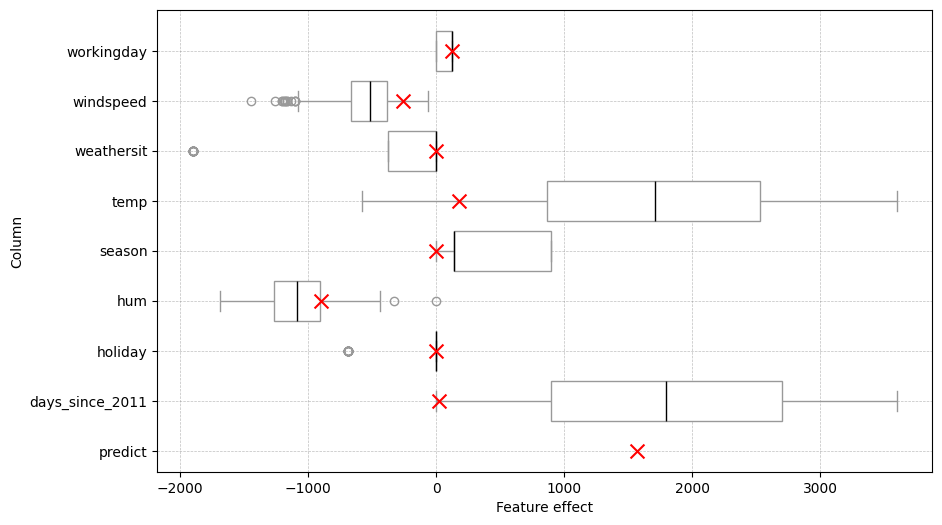

In [8]:
df_effect["predict"] = df_effect.sum(axis=1) + mod.params["Intercept"]

print(f"Predicted value for instance 6: {int(df_effect.iloc[5]['predict'])}")
print(f"Average predicted value:{int(df_effect['predict'].mean())}")
print(f"Actual value:{dat.iloc[5]['cnt']}")

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="Value",
    y="Column",
    data=df_melted_sorted,
    medianprops=dict(color="black"),
    color="white",
    ax=ax,
)
for col in df_effect.columns:
    ax.scatter(df_effect.iloc[5][col], col, marker="x", color="red", s=100, zorder=10)
ax.set_xlabel("Feature effect")
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

### 5.1.7 Sparse Linear Models

In [9]:
X_dummies = pd.get_dummies(
    X, columns=["season", "holiday", "workingday", "weathersit"], drop_first=False
)
X_dummies = X_dummies.rename(
    columns={
        "season_SPRING": "seasonSPRING",
        "season_SUMMER": "seasonSUMMER",
        "season_FALL": "seasonFALL",
        "season_WINTER": "seasonWINTER",
        "holiday_HOLIDAY": "holidayHOLIDAY",
        "workingday_WORKING DAY": "workingdayWORKING DAY",
        "weathersit_MISTY": "weathersitMISTY",
        "weathersit_RAIN/SNOW/STORM": "weathersitRAIN/SNOW/STORM",
    }
)
X_dummies[
    [
        "seasonSPRING",
        "seasonSUMMER",
        "seasonFALL",
        "seasonWINTER",
        "holidayHOLIDAY",
        "workingdayWORKING DAY",
        "weathersitMISTY",
        "weathersitRAIN/SNOW/STORM",
    ]
] = X_dummies[
    [
        "seasonSPRING",
        "seasonSUMMER",
        "seasonFALL",
        "seasonWINTER",
        "holidayHOLIDAY",
        "workingdayWORKING DAY",
        "weathersitMISTY",
        "weathersitRAIN/SNOW/STORM",
    ]
].astype(int)
X_dummies = X_dummies.drop(
    columns=[
        "holiday_NO HOLIDAY",
        "workingday_NO WORKING DAY",
        "weathersit_GOOD",
    ],
)

In [10]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X_dummies, y, test_size=0.2, random_state=0
)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

coefs = []
alphas = np.linspace(10, 10000, 1000)
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    coefs.append(model.coef_)

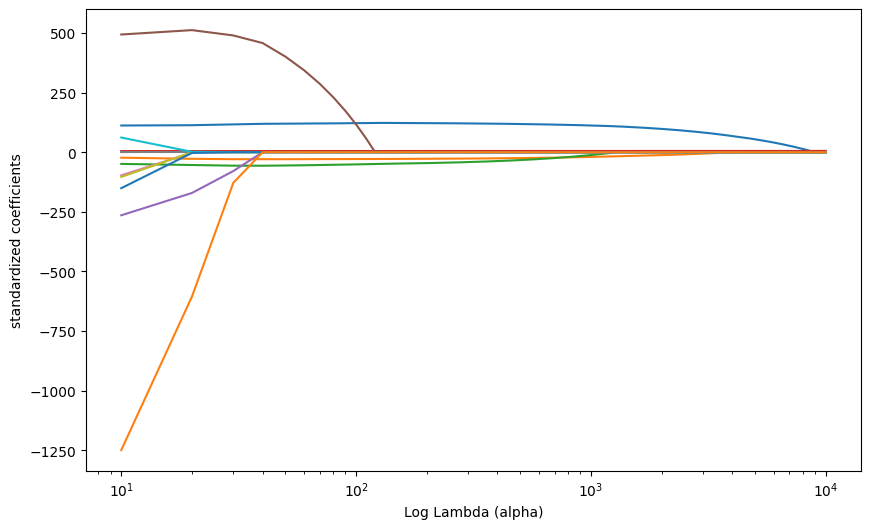

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlabel("Log Lambda (alpha)")
ax.set_ylabel("standardized coefficients")
plt.show()

In [12]:
model = Lasso(alpha=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
display(
    pd.DataFrame(
        model.coef_.reshape(-1), index=list(X_dummies.columns), columns=["Coefficient"]
    )
)

,Coefficient
temp,112.096315
hum,-19.709515
windspeed,-11.798163
days_since_2011,4.879422
seasonWINTER,-0.000000
seasonSPRING,0.000000
seasonSUMMER,-0.000000
seasonFALL,-0.000000
holidayHOLIDAY,-0.000000
workingdayWORKING DAY,0.000000


In [13]:
model = Lasso(alpha=250)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
display(
    pd.DataFrame(
        model.coef_.reshape(-1), index=list(X_dummies.columns), columns=["Coefficient"]
    )
)

,Coefficient
temp,121.393421
hum,-27.106320
windspeed,-43.515628
days_since_2011,4.746351
seasonWINTER,-0.000000
seasonSPRING,0.000000
seasonSUMMER,-0.000000
seasonFALL,0.000000
holidayHOLIDAY,-0.000000
workingdayWORKING DAY,0.000000
